In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import shap
from tqdm import tqdm
import seaborn as sns
import os
import itertools
import random
from dataclasses import dataclass
import shap

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
# from torch_geometric.data import Data
# from torch_geometric.nn import MessagePassing
# from torch_geometric.utils import add_self_loops, degree

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score,balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, matthews_corrcoef,make_scorer, classification_report
from sklearn.metrics import median_absolute_error, balanced_accuracy_score, precision_score, recall_score, f1_score

In [2]:
shap.initjs()

In [8]:
# def set_seeds(seed_value, use_cuda):
#     np.random.seed(seed_value)  # cpu vars
#     torch.manual_seed(seed_value)  # cpu  vars
#     random.seed(seed_value)  # Python
#     if use_cuda:
#         torch.cuda.manual_seed(seed_value)
#         torch.cuda.manual_seed_all(seed_value)  # gpu vars
#         torch.backends.cudnn.deterministic = True  # needed
#         torch.backends.cudnn.benchmark = False
        
# set_seeds(1168778, True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
mgus_list_aiims = open("/home/vivek/aiims_data_processing/scripts/mgus_list.txt").read().split("\n")
mgus_list_aiims = [i for i in mgus_list_aiims if i]
mm_list_aiims = open("/home/vivek/aiims_data_processing/scripts/mm_list.txt").read().split("\n")
mm_list_aiims = [i for i in mm_list_aiims if i]
mgus_list_ega = open("/home/vivek/ega_data_1901/scripts/ega_mgus_list.txt").read().split("\n")
mgus_list_ega = [i for i in mgus_list_ega if i]
mm_list_mmrf = open("/home/vivek/mmrf_data/mmrf_variant_callers/mmrf_mm_sample_list.txt").read().split("\n")
mm_list_mmrf = [i for i in mm_list_mmrf if i]
mm_list_mmrf = [i for i in mm_list_mmrf if not "PB" in i]

total_mm_list = mm_list_aiims + mm_list_mmrf
total_mgus_list = mgus_list_ega + mgus_list_aiims
total_list = total_mm_list + total_mgus_list

genelist = pd.read_csv('/home/vivek/jupyter_notebooks/bio_dgi_extension/feature_matrix/genes798feature26/CR-MGUS-10_10.csv', index_col=0).index.tolist()

# Local SHAP Analysis

# Preparing Custom Datasets for Dataloader

In [11]:
class mm_mgus_dataloader(torch.utils.data.Dataset):

    def __init__(self,sfile,lfile,root_dir):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        if isinstance(sfile,str):
            self.name_frame = open(sfile).read().split('\n')[:-1]
            self.label_frame = open(lfile).read().split('\n')[:-1]
        else:
            self.name_frame = sfile
            self.label_frame = lfile
            
        self.root_dir = root_dir

    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        
        sname = os.path.join(self.root_dir, self.name_frame[idx])
        feat = pd.read_csv(sname,index_col=0, header=0).to_numpy()
        scaler = StandardScaler()
        feat  =scaler.fit_transform(feat)
        label = torch.tensor(int(self.label_frame[idx])).float()
        sample = (feat,label,self.name_frame[idx])

        return sample

# Adjacency Matrix Processing

In [12]:
def preprocess_adj(A):
    '''
    Pre-process adjacency matrix
    :param A: adjacency matrix
    :return:
    '''
    I = np.eye(A.shape[0])
    A_hat = A + I # add self-loops
    D_hat_diag = np.sum(A_hat, axis=1)
    D_hat_diag_inv_sqrt = np.power(D_hat_diag, -0.5)
    D_hat_diag_inv_sqrt[np.isinf(D_hat_diag_inv_sqrt)] = 0.
    D_hat_inv_sqrt = np.diag(D_hat_diag_inv_sqrt)
    return np.dot(np.dot(D_hat_inv_sqrt, A_hat), D_hat_inv_sqrt)

# GCN Model Architecture

In [13]:
adj_mat = pd.read_csv("/home/vivek/jupyter_notebooks/bio_dgi_extension/adj_mats/adj_matrix_798_genes_ppi9_databases.csv", index_col=0, header=0)
learned_adj_mat = pd.read_csv('/home/vivek/jupyter_notebooks/bio_dgi_extension/ppi_string_merged/new_model4/best_performing_model/top_checkpoints_data/adj_mat_65.csv', index_col=0, header=0)

class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, acti=True):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim) # bias = False is also ok.
        torch.nn.init.xavier_uniform_(self.linear.weight.data)
        if acti:
            self.acti = nn.LeakyReLU(0.3)
        else:
            self.acti = None
    def forward(self, F):
        output = self.linear(F)
        if not self.acti:
            return output
        return self.acti(output)


In [14]:
"""
Model with consensus average of six consensus modules

"""


class GCN(nn.Module):
    """
        gcn_parameters = (input_dim_gcn, hidden_dim_gcn1, 
                          hidden_dim_gcn2,hidden_dim_gcn3, 
                          output_dim_gcn)
        linear_nn_parameters = (input_layer_linear, 
                                linear_hidden_layer2, no_classes)
        model_parameters = (gcn_parameters, linear_nn_parameters, 
                            drop_out, adj_dim)
    """
    
    def __init__(self, gcn_parameters, linear_nn_parameters, drop_out, adj_mat_dim):
        super(GCN, self).__init__()
        self.multihead_attn1 = nn.Sequential(
            nn.Dropout(drop_out),
            nn.Linear(adj_mat_dim, adj_mat_dim),
            nn.ReLU(),
            nn.LayerNorm(adj_mat_dim)
        )
        self.multihead_attn2 = nn.Sequential(
            nn.Dropout(drop_out),
            nn.Linear(adj_mat_dim, adj_mat_dim),
            nn.ReLU(),
            nn.LayerNorm(adj_mat_dim)
        )
        self.multihead_attn3 = nn.Sequential(
            nn.Dropout(drop_out),
            nn.Linear(adj_mat_dim, adj_mat_dim),
            nn.ReLU(),
            nn.LayerNorm(adj_mat_dim)
        )
        self.attn_layer = nn.Sequential(
            nn.Dropout(drop_out),
            nn.Linear(3,1),
            nn.ReLU()
        )
        self.gcn_layer1 = nn.Sequential(
            GCNLayer(gcn_parameters[0], gcn_parameters[1]),
            nn.Dropout(drop_out)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(linear_nn_parameters[0], linear_nn_parameters[1]),
            nn.LeakyReLU(0.3),
            # nn.Dropout(drop_out)
        )
    

    def forward(self, X, A = learned_adj_mat, adj_mask = adj_mat):
        adj_mask = torch.from_numpy(adj_mask.to_numpy()).float().reshape(-1,A.shape[0],A.shape[1]).to(device)
        A = torch.from_numpy(preprocess_adj(A)).float().reshape(-1,A.shape[0],A.shape[1]).to(device)
        attn1 = self.multihead_attn1(A).reshape(A.shape[1], A.shape[1])
        attn2 = self.multihead_attn2(A).reshape(A.shape[1], A.shape[1])
        attn3 = self.multihead_attn3(A).reshape(A.shape[1], A.shape[1])
        attn_layers = torch.stack((attn1, attn2, attn3), dim=1)
        out = []
        for dep in range(attn_layers.shape[0]):
            f = self.attn_layer(torch.transpose(attn_layers[dep,:,:],0,1))
            out.append(torch.transpose(f,0,1))
        x = torch.stack(out,1)
        x = torch.mul(x,adj_mask) #apply masking
        updated_adj_mat = x
        x = torch.matmul(updated_adj_mat, X.float())
        x = self.gcn_layer1(x)
        x = x.reshape(-1,798)
        x = self.fc1(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def compute_l1_loss(self, w):
          return torch.abs(w).sum()

In [15]:
loss = nn.NLLLoss(weight=torch.from_numpy(np.array([20.,1.])).float()).to(device)

In [16]:
def test(model, device, test_loader, rand_adj_matrix, show_perf = True):
    model.eval()
    test_loss = 0
    correct = 0
    target2, pred2 = [], []
    output_pred_prob1 = torch.empty([0]).to(device)
    output_pred_prob = torch.empty([0,2]).to(device)
    correctly_predicted_test_samples = []
    correctly_predicted_test_samples_idx = []
    correctly_predicted_test_samples_name = []
    if torch.is_tensor(rand_adj_matrix):
        rand_adj_matrix = torch.abs(rand_adj_matrix).reshape(824,824)
        rand_adj_matrix = rand_adj_matrix.detach().cpu().numpy()
    model.eval()
    with torch.no_grad():
        for data, target, sample_names in test_loader:
            data = data.to(device).float()
            target = target.long().to(device)
            output = model(data, rand_adj_matrix)
            test_loss += loss(output, target.view(output.shape[0])).item()  # sum up batch loss
            pred1 = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            corerct_idx = torch.where(pred1.eq(target.view_as(pred1)) == True)
            correctly_predicted_test_samples_idx.append(corerct_idx[0])
            correctly_predicted_test_samples.append([data[i] for i in correctly_predicted_test_samples_idx[-1]])
            correctly_predicted_test_samples_name.append([sample_names[i] for i in correctly_predicted_test_samples_idx[-1]])
            correct += pred1.eq(target.view_as(pred1)).sum().item()
            target2.append([i.cpu().item() for i in target])
            pred2.append([j.cpu().item() for j in pred1])
            output_pred_prob1 = torch.cat((output_pred_prob1,torch.max(output, axis=1).values))
            output_pred_prob = torch.cat((output_pred_prob,output))

    # print(f'output_pred_prob : {output_pred_prob}, pred2 : {pred2}')
    target2 = list(itertools.chain.from_iterable(target2))
    pred2 = list(itertools.chain.from_iterable(pred2))
    test_loss /= test_loader.__len__()
    acc = 100. * correct / len(test_loader.dataset)
    cm = confusion_matrix(target2, pred2)   
    cm = {'tn': cm[0, 0], 'fp': cm[0, 1],
          'fn': cm[1, 0], 'tp': cm[1, 1]}
    class_report = classification_report(target2,pred2,output_dict=True)
    f1_score_cal1 = class_report['0']['f1-score']
    prec1 = class_report['0']['precision']
    rec1 = class_report['0']['recall']
    f1_score_cal2 = class_report['1']['f1-score']
    prec2 = class_report['1']['precision']
    rec2 = class_report['1']['recall']
    f1_score_cal = f1_score(target2, pred2)
    f1_score_weighted = f1_score(target2, pred2,average='weighted')
    f1_score_weighted1 = f1_score(target2, pred2,average='weighted',labels=[0])
    f1_score_weighted2 = f1_score(target2, pred2,average='weighted',labels=[1])
    f1_score_micro = f1_score(target2, pred2,average='micro')
    f1_score_macro = f1_score(target2, pred2,average='macro')
    acc = accuracy_score(target2, pred2)
    acc_balanced = balanced_accuracy_score(target2, pred2)
    prec = precision_score(target2, pred2, average = 'weighted')
    rec = recall_score(target2, pred2, average = 'weighted')
    roc = roc_auc_score(target2, output_pred_prob.cpu()[:, 1], average='weighted')
    mcc = matthews_corrcoef(target2, pred2)   
    # mgus_prec, mgus_rec,_= precision_recall_curve(target2, output_pred_prob1.cpu().numpy())
    # auc2 = auc(mgus_rec,mgus_prec)

    perf_mat = {'accuracy':acc,
                'balanced_accuracy':acc_balanced,
                'f1_score':f1_score_cal,
                'f1_score_MM':f1_score_cal1,
                'f1_score_MGUS':f1_score_cal2,
                'f1_score_weighted':f1_score_weighted,
                'f1_score_weighted_MM':f1_score_weighted1,
                'f1_score_weighted_MGUS':f1_score_weighted2,
                'f1_score_micro':f1_score_micro,
                'f1_score_macro':f1_score_macro,
                'precision':prec,
                'precision_MM':prec1,
                'precision_MGUS':prec2,
                'recall': rec,
                'recall_MM': rec1,
                'recall_MGUS': rec2,
                'roc':roc,
                'mcc': mcc,
                'confusioin_matrix':cm
               }
    if show_perf:
        print(perf_mat)

#     print('Test set: Average loss: {:.4f}, MGUS Recall: {}/{} ({:.2f}%)'.format(
#         test_loss, cm['tp'], cm['tp']+cm['fn'],
#         100. * cm['tp'] / (cm['tp']+cm['fn'])))
    
    return test_loss, acc,perf_mat, correctly_predicted_test_samples, correctly_predicted_test_samples_name

In [17]:
root_dir = '/home/vivek/jupyter_notebooks/bio_dgi_extension/feature_matrix/genes798feature26'
sfile = '/home/vivek/top_model_results/NN/samples_without_PB.txt'
lfile = '/home/vivek/top_model_results/NN/labels_without_PB_new.txt'
X = open(sfile).read().split('\n')
Y = open(lfile).read().split('\n')

**Fold-1 Model Shap Values**

In [18]:
mm_mgus_dataset = mm_mgus_dataloader(sfile = sfile, lfile = lfile, root_dir = root_dir)
mm_mgus_dataloader = DataLoader(mm_mgus_dataset,batch_size=24,shuffle=False, num_workers=20)

In [13]:
# model = GCN((26,1),(798,2),0.75,798).to(device)
# print(model)

In [14]:
model = GCN((26,1),(798,2),0.75,798).to(device)
learned_adj_mat = pd.read_csv('/home/naushad/bio-dgi-extension/ppi_merged/1431339/learned_adj_mat/fold_1/adj_mat_167.csv', index_col=0, header=0)

model.load_state_dict(torch.load('/home/naushad/bio-dgi-extension/ppi_merged/1431339/GCN_model_1_checkpoint.pt')["model_state_dict"])
model.eval()
te, te_acc,perf_mat, corr_pred_test_sample, corr_pred_test_sample_names = test(model, device, mm_mgus_dataloader, learned_adj_mat, show_perf=True)

corr_pred_test_sample_dict = list(itertools.chain.from_iterable(corr_pred_test_sample))
corr_pred_test_sample_name_dict = list(itertools.chain.from_iterable(corr_pred_test_sample_names))
    
#Random Sampling of 250 correctly mapped samples
new_idx = list(np.arange(len(corr_pred_test_sample_dict)))
new_idx = random.sample(new_idx,250)
rand_data = [corr_pred_test_sample_dict[i] for i in new_idx]
rand_data2 = torch.vstack(rand_data).reshape(-1,798,26)

# Applying SHAP
print(f'Starting model interpretation using SHAP')
explainer = shap.DeepExplainer(model, rand_data2)
shap_values_fold1 = {}
for i in tqdm(range(len(corr_pred_test_sample_dict))):
    val = corr_pred_test_sample_dict[i]
    shap_values_fold1[corr_pred_test_sample_name_dict[i]] = {'shap_values':explainer.shap_values(val.reshape(-1,val.shape[0],val.shape[1])),
                                                                                           'data':corr_pred_test_sample_dict[i].cpu().numpy(),
                                                                                           'base_values':explainer.expected_value}

# deleting the model to load a new one
del model

{'accuracy': 0.913509060955519, 'balanced_accuracy': 0.9467035388793312, 'f1_score': 0.9523377212891511, 'f1_score_MM': 0.5333333333333333, 'f1_score_MGUS': 0.9523377212891511, 'f1_score_weighted': 0.931283958797137, 'f1_score_weighted_MM': 0.5333333333333333, 'f1_score_weighted_MGUS': 0.952337721289151, 'f1_score_micro': 0.913509060955519, 'f1_score_macro': 0.7428355273112421, 'precision': 0.9672314480499475, 'precision_MM': 0.36585365853658536, 'precision_MGUS': 0.9990476190476191, 'recall': 0.913509060955519, 'recall_MM': 0.9836065573770492, 'recall_MGUS': 0.9098005203816132, 'roc': 0.9791278631652284, 'mcc': 0.5709688118250476, 'confusioin_matrix': {'tn': 60, 'fp': 1, 'fn': 104, 'tp': 1049}}
Starting model interpretation using SHAP


100%|██████████| 1109/1109 [10:14<00:00,  1.80it/s]


**Fold-2 Model SHAP Values**

In [15]:
model = GCN((26,1),(798,2),0.75,798).to(device)
learned_adj_mat = pd.read_csv('/home/naushad/bio-dgi-extension/ppi_merged/1431339/learned_adj_mat/fold_1/adj_mat_118.csv', index_col=0, header=0)

model.load_state_dict(torch.load('/home/naushad/bio-dgi-extension/ppi_merged/1431339/GCN_model_2_checkpoint.pt')["model_state_dict"])
model.eval()
te, te_acc,perf_mat, corr_pred_test_sample, corr_pred_test_sample_names = test(model, device, mm_mgus_dataloader, learned_adj_mat, show_perf=True)

corr_pred_test_sample_dict = list(itertools.chain.from_iterable(corr_pred_test_sample))
corr_pred_test_sample_name_dict = list(itertools.chain.from_iterable(corr_pred_test_sample_names))
    
#Random Sampling of 250 correctly mapped samples
new_idx = list(np.arange(len(corr_pred_test_sample_dict)))
new_idx = random.sample(new_idx,250)
rand_data = [corr_pred_test_sample_dict[i] for i in new_idx]
rand_data2 = torch.vstack(rand_data).reshape(-1,798,26)

# Applying SHAP
print(f'Starting model interpretation using SHAP')
explainer = shap.DeepExplainer(model, rand_data2) 
shap_values_fold2 = {}
for i in tqdm(range(len(corr_pred_test_sample_dict))):
    val = corr_pred_test_sample_dict[i]
    shap_values_fold2[corr_pred_test_sample_name_dict[i]] = {'shap_values':explainer.shap_values(val.reshape(-1,val.shape[0],val.shape[1])),
                                                                                           'data':corr_pred_test_sample_dict[i].cpu().numpy(),
                                                                                           'base_values':explainer.expected_value}
del model

{'accuracy': 0.9588138385502472, 'balanced_accuracy': 0.9783174327840416, 'f1_score': 0.9778368794326242, 'f1_score_MM': 0.7093023255813954, 'f1_score_MGUS': 0.9778368794326242, 'f1_score_weighted': 0.9643437922951242, 'f1_score_weighted_MM': 0.7093023255813954, 'f1_score_weighted_MGUS': 0.9778368794326241, 'f1_score_micro': 0.9588138385502472, 'f1_score_macro': 0.8435696025070099, 'precision': 0.9773661635276132, 'precision_MM': 0.5495495495495496, 'precision_MGUS': 1.0, 'recall': 0.9588138385502472, 'recall_MM': 1.0, 'recall_MGUS': 0.9566348655680833, 'roc': 0.9953364707889611, 'mcc': 0.7250643140138219, 'confusioin_matrix': {'tn': 61, 'fp': 0, 'fn': 50, 'tp': 1103}}
Starting model interpretation using SHAP


100%|██████████| 1164/1164 [10:16<00:00,  1.89it/s]


**Fold-3 Model SHAP Values**

In [16]:
model = GCN((26,1),(798,2),0.75,798).to(device)
learned_adj_mat = pd.read_csv('/home/naushad/bio-dgi-extension/ppi_merged/1431339/learned_adj_mat/fold_1/adj_mat_61.csv', index_col=0, header=0)

model.load_state_dict(torch.load('/home/naushad/bio-dgi-extension/ppi_merged/1431339/GCN_model_3_checkpoint.pt')["model_state_dict"])
model.eval()
te, te_acc,perf_mat, corr_pred_test_sample, corr_pred_test_sample_names = test(model, device, mm_mgus_dataloader, learned_adj_mat, show_perf=True)

corr_pred_test_sample_dict = list(itertools.chain.from_iterable(corr_pred_test_sample))
corr_pred_test_sample_name_dict = list(itertools.chain.from_iterable(corr_pred_test_sample_names))
    
#Random Sampling of 250 correctly mapped samples
new_idx = list(np.arange(len(corr_pred_test_sample_dict)))
new_idx = random.sample(new_idx,250)
rand_data = [corr_pred_test_sample_dict[i] for i in new_idx]
rand_data2 = torch.vstack(rand_data).reshape(-1,798,26)

# Applying SHAP
print(f'Starting model interpretation using SHAP')
explainer = shap.DeepExplainer(model, rand_data2) 
shap_values_fold3 = {}
for i in tqdm(range(len(corr_pred_test_sample_dict))):
    val = corr_pred_test_sample_dict[i]
    shap_values_fold3[corr_pred_test_sample_name_dict[i]] = {'shap_values':explainer.shap_values(val.reshape(-1,val.shape[0],val.shape[1])),
                                                                                           'data':corr_pred_test_sample_dict[i].cpu().numpy(),
                                                                                           'base_values':explainer.expected_value}
del model

{'accuracy': 0.9695222405271828, 'balanced_accuracy': 0.9761918302930346, 'f1_score': 0.98370761778952, 'f1_score_MM': 0.7643312101910829, 'f1_score_MGUS': 0.98370761778952, 'f1_score_weighted': 0.9726845857767483, 'f1_score_weighted_MM': 0.7643312101910829, 'f1_score_weighted_MGUS': 0.98370761778952, 'f1_score_micro': 0.9695222405271828, 'f1_score_macro': 0.8740194139903015, 'precision': 0.9803078205079088, 'precision_MM': 0.625, 'precision_MGUS': 0.9991055456171736, 'recall': 0.9695222405271828, 'recall_MM': 0.9836065573770492, 'recall_MGUS': 0.96877710320902, 'roc': 0.9971563846274153, 'mcc': 0.7709655790805122, 'confusioin_matrix': {'tn': 60, 'fp': 1, 'fn': 36, 'tp': 1117}}
Starting model interpretation using SHAP


100%|██████████| 1177/1177 [10:46<00:00,  1.82it/s]


**Fold-4 Model SHAP Values**

In [17]:
model = GCN((26,1),(798,2),0.75,798).to(device)
learned_adj_mat = pd.read_csv('/home/naushad/bio-dgi-extension/ppi_merged/1431339/learned_adj_mat/fold_1/adj_mat_143.csv', index_col=0, header=0)

model.load_state_dict(torch.load('/home/naushad/bio-dgi-extension/ppi_merged/1431339/GCN_model_4_checkpoint.pt')["model_state_dict"])
model.eval()
te, te_acc,perf_mat, corr_pred_test_sample, corr_pred_test_sample_names = test(model, device, mm_mgus_dataloader, learned_adj_mat, show_perf=True)

corr_pred_test_sample_dict = list(itertools.chain.from_iterable(corr_pred_test_sample))
corr_pred_test_sample_name_dict = list(itertools.chain.from_iterable(corr_pred_test_sample_names))
    
#Random Sampling of 250 correctly mapped samples
new_idx = list(np.arange(len(corr_pred_test_sample_dict)))
new_idx = random.sample(new_idx,250)
rand_data = [corr_pred_test_sample_dict[i] for i in new_idx]
rand_data2 = torch.vstack(rand_data).reshape(-1,798,26)

# Applying SHAP
print(f'Starting model interpretation using SHAP')
explainer = shap.DeepExplainer(model, rand_data2) 
shap_values_fold4 = {}
for i in tqdm(range(len(corr_pred_test_sample_dict))):
    val = corr_pred_test_sample_dict[i]
    shap_values_fold4[corr_pred_test_sample_name_dict[i]] = {'shap_values':explainer.shap_values(val.reshape(-1,val.shape[0],val.shape[1])),
                                                                                           'data':corr_pred_test_sample_dict[i].cpu().numpy(),
                                                                                           'base_values':explainer.expected_value}
    
del model

{'accuracy': 0.9398682042833608, 'balanced_accuracy': 0.9683434518647007, 'f1_score': 0.9673085535154501, 'f1_score_MM': 0.6256410256410255, 'f1_score_MGUS': 0.9673085535154501, 'f1_score_weighted': 0.9501407452779377, 'f1_score_weighted_MM': 0.6256410256410255, 'f1_score_weighted_MGUS': 0.96730855351545, 'f1_score_micro': 0.9398682042833608, 'f1_score_macro': 0.7964747895782378, 'precision': 0.9726265706066044, 'precision_MM': 0.4552238805970149, 'precision_MGUS': 1.0, 'recall': 0.9398682042833608, 'recall_MM': 1.0, 'recall_MGUS': 0.9366869037294016, 'roc': 0.9906018511936076, 'mcc': 0.6529948293976766, 'confusioin_matrix': {'tn': 61, 'fp': 0, 'fn': 73, 'tp': 1080}}
Starting model interpretation using SHAP


100%|██████████| 1141/1141 [10:16<00:00,  1.85it/s]


**Fold-5 Model SHAP Values**

In [18]:
model = GCN((26,1),(798,2),0.75,798).to(device)
learned_adj_mat = pd.read_csv('/home/naushad/bio-dgi-extension/ppi_merged/1431339/learned_adj_mat/fold_1/adj_mat_106.csv', index_col=0, header=0)

model.load_state_dict(torch.load('/home/naushad/bio-dgi-extension/ppi_merged/1431339/GCN_model_5_checkpoint.pt')["model_state_dict"])
model.eval()
te, te_acc,perf_mat, corr_pred_test_sample, corr_pred_test_sample_names = test(model, device, mm_mgus_dataloader, learned_adj_mat, show_perf=True)

corr_pred_test_sample_dict = list(itertools.chain.from_iterable(corr_pred_test_sample))
corr_pred_test_sample_name_dict = list(itertools.chain.from_iterable(corr_pred_test_sample_names))
    
#Random Sampling of 250 correctly mapped samples
new_idx = list(np.arange(len(corr_pred_test_sample_dict)))
new_idx = random.sample(new_idx,250)
rand_data = [corr_pred_test_sample_dict[i] for i in new_idx]
rand_data2 = torch.vstack(rand_data).reshape(-1,798,26)

# Applying SHAP
print(f'Starting model interpretation using SHAP')
explainer = shap.DeepExplainer(model, rand_data2) 
shap_values_fold5 = {}
for i in tqdm(range(len(corr_pred_test_sample_dict))):
    val = corr_pred_test_sample_dict[i]
    shap_values_fold5[corr_pred_test_sample_name_dict[i]] = {'shap_values':explainer.shap_values(val.reshape(-1,val.shape[0],val.shape[1])),
                                                                                           'data':corr_pred_test_sample_dict[i].cpu().numpy(),
                                                                                           'base_values':explainer.expected_value}
    
del model

{'accuracy': 0.971169686985173, 'balanced_accuracy': 0.9848222029488292, 'f1_score': 0.9845882870981947, 'f1_score_MM': 0.7770700636942676, 'f1_score_MGUS': 0.9845882870981947, 'f1_score_weighted': 0.9741610946536811, 'f1_score_weighted_MM': 0.7770700636942676, 'f1_score_weighted_MGUS': 0.9845882870981948, 'f1_score_micro': 0.971169686985173, 'f1_score_macro': 0.8808291753962312, 'precision': 0.981680738605162, 'precision_MM': 0.6354166666666666, 'precision_MGUS': 1.0, 'recall': 0.971169686985173, 'recall_MM': 1.0, 'recall_MGUS': 0.9696444058976583, 'roc': 0.9989478623121436, 'mcc': 0.7849383518770569, 'confusioin_matrix': {'tn': 61, 'fp': 0, 'fn': 35, 'tp': 1118}}
Starting model interpretation using SHAP


100%|██████████| 1179/1179 [10:14<00:00,  1.92it/s]


In [19]:
shap_dict = dict()
shap_dict['fold_1'] = shap_values_fold1
shap_dict['fold_2'] = shap_values_fold2
shap_dict['fold_3'] = shap_values_fold3
shap_dict['fold_4'] = shap_values_fold4
shap_dict['fold_5'] = shap_values_fold5

with open('shap_dict.pickle', 'wb') as handle:
    pickle.dump(shap_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load Shap analysis from saved pickles

In [4]:
with open('shap_values_fold1.pickle','rb') as handle:
    shap_values_fold1 = pickle.load(handle)

with open('shap_values_fold2.pickle','rb') as handle:
    shap_values_fold2 = pickle.load(handle)
    
with open('shap_values_fold3.pickle','rb') as handle:
    shap_values_fold3 = pickle.load(handle)
    
with open('shap_values_fold4.pickle','rb') as handle:
    shap_values_fold4 = pickle.load(handle)
    
with open('shap_values_fold5.pickle','rb') as handle:
    shap_values_fold5 = pickle.load(handle)

In [5]:
correctly_mapped_samples = list(set(list(shap_values_fold1['fold_1'].keys()) + list(shap_values_fold2['fold_2'].keys()) + list(shap_values_fold3['fold_3'].keys()) + list(shap_values_fold4['fold_4'].keys()) + list(shap_values_fold5['fold_5'].keys())))
print(correctly_mapped_samples.__len__(),correctly_mapped_samples[:5])

1199 ['MMRF_1309_2_BM_CD138pos.csv', 'MMRF_1882_1_BM_CD138pos.csv', 'MMRF_2507_1_BM_CD138pos.csv', 'MMRF_1890_1_BM_CD138pos.csv', 'MMRF_1054_1_BM_CD138pos.csv']


In [6]:
# sample_cls_dict = {}
# for sam in tqdm(correctly_mapped_samples):
#     cls_count = 0
#     cls_list = []
#     if sam in shap_values_fold1.keys():
#         cls_count += 1
#         cls_list.append('fold1')
#     if sam in shap_values_fold2.keys():
#         cls_count += 1
#         cls_list.append('fold2')
#     if sam in shap_values_fold3.keys():
#         cls_count += 1
#         cls_list.append('fold3')
#     if sam in shap_values_fold4.keys():
#         cls_count += 1
#         cls_list.append('fold4')
#     if sam in shap_values_fold5.keys():
#         cls_count += 1
#         cls_list.append('fold5')
    
#     sample_cls_dict[sam] = [cls_count,cls_list]

# # sample_cls_dict

In [7]:
# backup_shap_dict = {}
# backup_shap_dict['fold1'] = shap_values_fold1
# backup_shap_dict['fold2'] = shap_values_fold2
# backup_shap_dict['fold3'] = shap_values_fold3
# backup_shap_dict['fold4'] = shap_values_fold4
# backup_shap_dict['fold5'] = shap_values_fold5

# with open('shap_values.pickle', 'wb') as handle:
#     pickle.dump(backup_shap_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
def get_shap_samplewise(sample, shap_values_foldno):
    if sample in shap_values_foldno.keys():
        if sample in total_mm_list: #for MM sample
            shap_values = shap_values_foldno[sample]['shap_values'][0]
            exp_value = shap_values_foldno[sample]['base_values'][0]
        else: # For MGUS Sample
            shap_values = shap_values_foldno[sample]['shap_values'][1]
            exp_value = shap_values_foldno[sample]['base_values'][1]

        data_points = shap_values_foldno[sample]['data']
    else:
        print(f'The sample was not correctly mapped in {shap_values_foldno}')
        shap_values, exp_values, data_points = [], [], []
    
    return shap_values, exp_value, data_points

In [7]:
def get_shap_samplewise2(sample):
    correct_cls_dict = {}
    if sample in shap_values_fold1['fold_1'].keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold1['fold_1'])
        correct_cls_dict['fold1'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold2['fold_2'].keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold2['fold_2'])
        correct_cls_dict['fold2'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold3['fold_3'].keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold3['fold_3'])
        correct_cls_dict['fold3'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold4['fold_4'].keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold4['fold_4'])
        correct_cls_dict['fold4'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold5['fold_5'].keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold5['fold_5'])
        correct_cls_dict['fold_5'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    return correct_cls_dict

In [8]:
def dominent_shap_for_each_fold(shap_dict, foldno):
    ashap = shap_dict[foldno]['shap_values'].reshape(798,26)
    negative_shap = [(sum(j[j<0])) for j in ashap]
    positive_shap = [(sum(j[j>0])) for j in ashap]
    dominent_shap = [i if np.abs(i)>j else j for (i,j) in zip(negative_shap,positive_shap)]
    return dominent_shap

In [9]:
def norm_data_for_dominent_shap(shap_dict, foldno):
    ashap = shap_dict[foldno]['shap_values'].reshape(798,26)
    adata = shap_dict[foldno]['data']
    dominent_shap = dominent_shap_for_each_fold(shap_dict, foldno)
    nor_shap_data = []
    for dom in dominent_shap:
        shap_index = dominent_shap.index(dom)
        if dom <0:
            nor_shap_data.append(sum([list(adata[shap_index][np.where(ashap[shap_index]==i)])[0] for i in ashap[shap_index] if i<0]))
        else:
            nor_shap_data.append(sum([list(adata[shap_index][np.where(ashap[shap_index]==i)])[0] for i in ashap[shap_index] if i>0]))
    return dominent_shap, nor_shap_data

In [10]:
# sample = correctly_mapped_samples[0]
def get_shap_features(sample):
    sample_shap = get_shap_samplewise2(sample)
    dominent_shap_dict = {}
    best_shap_values = []
    data_points = []
    expected_values = []
#     print(f'Checking {sample} shap values in {len(sample_shap.keys())}.')
    for k,v in sample_shap.items():
        shap_out1, shap_out2 = norm_data_for_dominent_shap(sample_shap,k)
        dominent_shap_dict[k] = {}
        dominent_shap_dict[k]['shap_values'] = shap_out1
        dominent_shap_dict[k]['data'] = shap_out2
        dominent_shap_dict[k]['base_value'] = sample_shap[k]['base_value']

    for j in range(798):
        shap_across_folds = [dominent_shap_dict[k]['shap_values'][j] for k in dominent_shap_dict.keys()]
        data_points_across_folds = [dominent_shap_dict[k]['data'][j] for k in dominent_shap_dict.keys()]
        base_value_across_folds = [dominent_shap_dict[k]['base_value'] for k in dominent_shap_dict.keys()]
        try:
            idx = shap_across_folds.index(max(np.abs(shap_across_folds)))
            best_shap_values.append(shap_across_folds[idx])
            data_points.append(data_points_across_folds[idx])
            expected_values.append(base_value_across_folds[idx])
        except: 
            idx = shap_across_folds.index(-max(np.abs(shap_across_folds)))
            best_shap_values.append(shap_across_folds[idx])
            data_points.append(data_points_across_folds[idx])
            expected_values.append(base_value_across_folds[idx])    
            
    return best_shap_values, data_points, np.mean(expected_values)

In [14]:
shap_values, data_points, expected_values = get_shap_features('MMRF_2039_2_BM_CD138pos.csv')

# @dataclass
# class shap_data:
#     base_values: float 
#     values: float     
#     data: float
#     feature_names : list

# p = shap_data(expected_values,
#               np.array(shap_values),
#               np.array(data_points),
#               genelist)

# shap.plots.waterfall(p,max_display = 100, show=False)
# plt.savefig('MMRF_2039_2_BM_CD138pos_waterfall_plot.png',dpi=400)

In [15]:
shap_df = pd.DataFrame(columns = genelist)
shap_data_df = pd.DataFrame(columns = genelist)
shap_expected_value = []
for sam in tqdm(correctly_mapped_samples):
    shap_values, data_points, expected_values = get_shap_features(sam)
    shap_df.loc[sam] = shap_values
    shap_data_df.loc[sam] = data_points
    shap_expected_value.append(expected_values)
    
print(shap_df.shape, shap_data_df.shape, len(shap_expected_value))

100%|██████████| 1199/1199 [08:06<00:00,  2.46it/s]

(1199, 798) (1199, 798) 1199


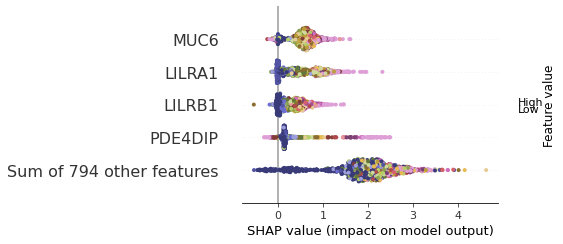

In [34]:
shap.plots.beeswarm(shap.Explanation(np.array(shap_df),
                                     np.array(shap_expected_value),
                                     np.array(shap_data_df),
                                     feature_names = genelist),
                    max_display = 5,
                    show=False,
                    # plot_size = (12,100),
                    color = plt.get_cmap("tab20b"))#
plt.yticks(fontsize=16)
# plt.xticks(np.arange(-2,2.0,0.5),fontsize=10)
plt.tight_layout()
plt.savefig('MM_MGUS_beeswarm_plot_50.png',dpi=600)
plt.savefig('MM_MGUS_beeswarm_plot_50.svg', dpi=600)

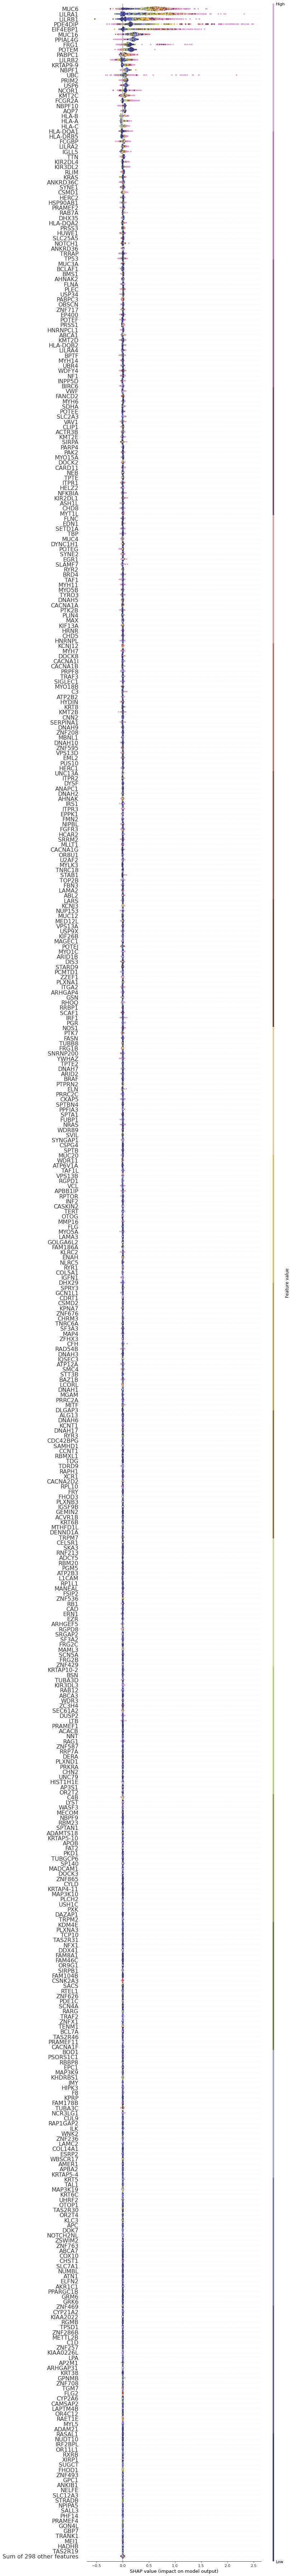

In [44]:
shap.plots.beeswarm(shap.Explanation(np.array(shap_df),
                                     np.array(shap_expected_value),
                                     np.array(shap_data_df),
                                     feature_names = genelist),
                    max_display = 501,
                    show=False,
                    plot_size = (12,100),
                    color = plt.get_cmap("tab20b"))#
plt.yticks(fontsize=16)
# plt.xticks(np.arange(-2,2.0,0.5),fontsize=10)
plt.tight_layout()
plt.savefig('MM_MGUS_beeswarm_plot_500.png',dpi=600)
plt.savefig('MM_MGUS_beeswarm_plot_500.svg', dpi=600)

In [37]:
shap_df.head()

,ABCA1,ABCA3,ABCA7,ABL2,ACACB,ACTR3B,ACVR1B,ADAM21,ADAMTS18,ADAMTSL3,...,ZNF845,ZNF85,ZNF850,ZNF860,ZNF865,ZNFX1,ZSCAN10,ZSWIM2,ZXDA,ZZEF1
SM0124.csv,-0.004372,0.000401,0.003449,0.011294,-0.001322,-0.003709,0.000496,0.000387,0.000520,-0.000483,...,0.000068,0.000117,-0.000014,0.000046,-0.000385,0.000397,-0.000038,-0.000269,0.000479,0.000406
MMRF_2602_1_BM_CD138pos.csv,0.007638,-0.000504,0.000590,0.004098,0.000985,0.005975,0.001403,0.000599,-0.002210,0.000440,...,0.000174,0.000665,0.000085,-0.000264,0.000405,0.000723,0.000263,0.000518,0.000335,0.003173
MMRF_2675_1_BM_CD138pos.csv,0.003744,-0.001022,0.000714,0.002248,-0.001084,-0.006945,-0.001852,0.001046,-0.001465,0.000180,...,0.000341,-0.000534,0.000136,0.000091,0.000567,0.001027,0.000385,-0.001126,-0.000857,0.003201
CR-MGUS-72_72.csv,-0.005996,-0.000362,0.000722,0.001414,-0.001210,0.001198,0.000485,0.000384,0.001192,-0.000405,...,-0.000128,0.000220,0.000013,-0.000079,0.000122,0.000298,0.000055,0.000226,0.000461,-0.001627
MMRF_1991_1_BM_CD138pos.csv,0.013465,-0.000735,0.000850,-0.003058,0.000710,-0.006971,0.001491,0.000761,-0.001662,0.000468,...,0.000226,0.000366,0.000070,-0.000222,0.000381,0.000751,0.000300,-0.004842,0.000249,0.002046


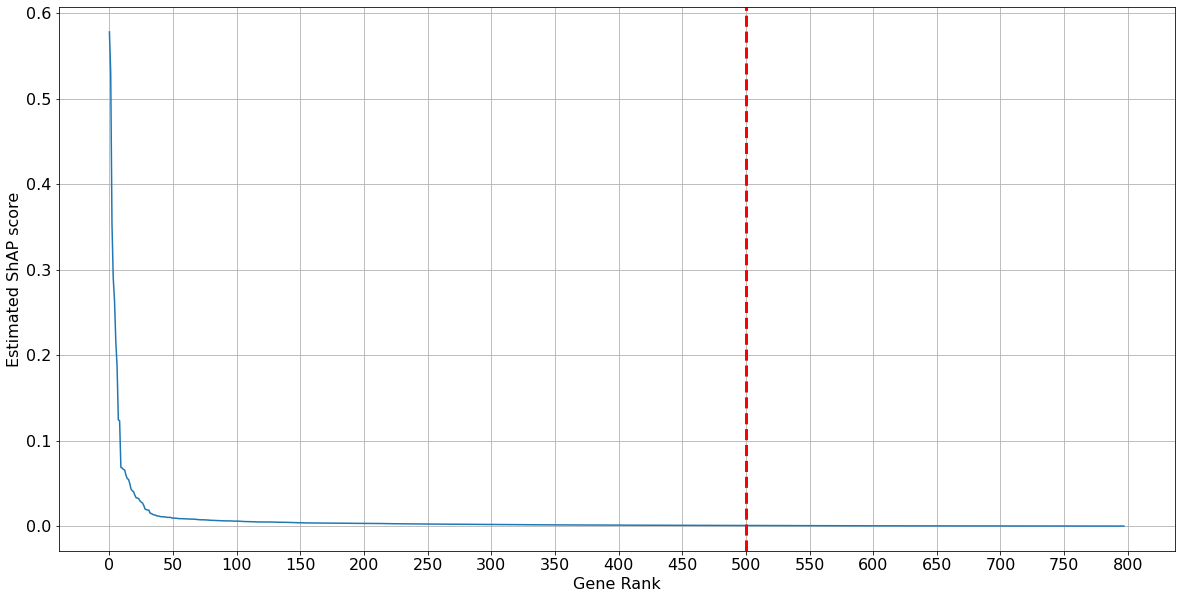

In [16]:
final_shap_values = list(shap_df.abs().mean().sort_values(ascending=False))

plt.figure(figsize=(20,10))
plt.plot(final_shap_values)
plt.xticks(np.arange(0,850,50),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Gene Rank',fontsize=16)
plt.ylabel('Estimated ShAP score',fontsize=16)
plt.axvline(x=500, color='red', linestyle='--', linewidth=3)
plt.grid()
# plt.savefig('MM_MGUS_shap_score.svg',dpi=600)

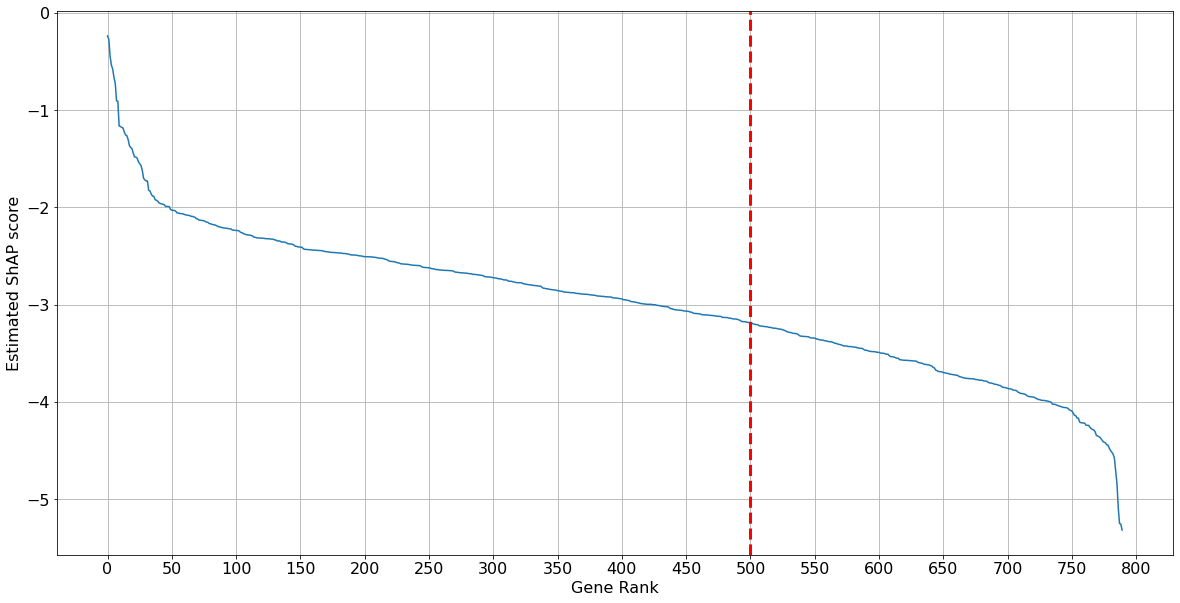

In [92]:
final_shap_values1 = [np.log10(i) for i in final_shap_values]

plt.figure(figsize=(20,10))
plt.plot(final_shap_values1)
plt.xticks(np.arange(0,850,50),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Gene Rank',fontsize=16)
plt.ylabel('Estimated ShAP score',fontsize=16)
plt.axvline(x=500, color='red', linestyle='--', linewidth=3)
plt.grid()
# plt.savefig('MM_MGUS_shap_score.svg',dpi=600)

In [93]:
final_shap_values1[499]

-3.186291545775926

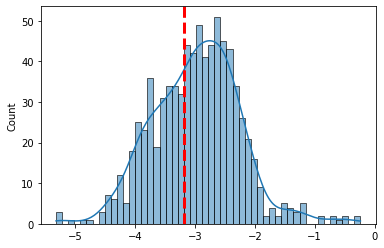

In [94]:
sns.histplot(final_shap_values1, bins=50, kde=True)
plt.axvline(x=-3.18, color='red', linestyle='--', linewidth=3)

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

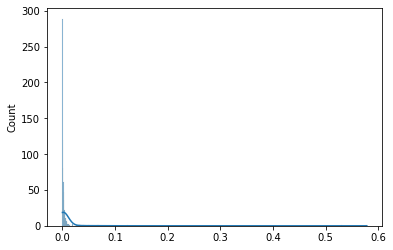

In [24]:
sns.histplot(final_shap_values, kde=True)

In [30]:
print(max(final_shap_values), min(final_shap_values), np.median(final_shap_values))

0.578380035873613 0.0 0.0011552018232083585


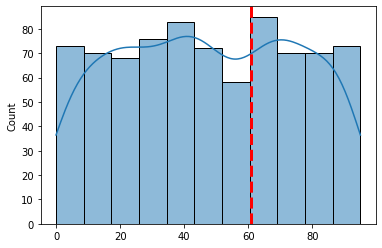

In [87]:
random_list = sorted([random.randint(0, 95) for i in range(798)])
cut_off = random_list[500]

sns.histplot(random_list, kde=True)
plt.axvline(x=cut_off, color='red', linestyle='--', linewidth=3)

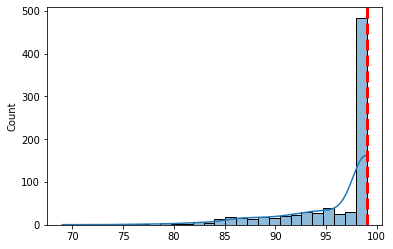

In [91]:
poisson_list = np.random.poisson(100, 798)
poisson_list = np.clip(poisson_list, 0, 99)
cut_off = poisson_list[500]

sns.histplot(poisson_list, kde=True)
plt.axvline(x=cut_off, color='red', linestyle='--', linewidth=3)

In [19]:
df = pd.DataFrame(shap_df.abs().mean().sort_values(ascending=False))
df["rank"] = np.arange(1,799)
df.columns = ['shap_score','rank']
df.to_excel('gene798_ranking.xlsx')
df.head()

,shap_score,rank
MUC6,0.578380,1
LILRA1,0.530628,2
LILRB1,0.354037,3
PDE4DIP,0.289928,4
EIF4EBP1,0.264055,5
